<a href="https://colab.research.google.com/github/cb190/IS_4487/blob/main/Lab_6_Carson_Braswell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 6 Lab, IS 4487

The purpose of this lab is to prepare you to complete today's project quiz. Here are the questions you need to be able to answer.

- Understand model accuracy.  And:  Why is it a performance metric for classification and not regression?
- Calculate accuracy for a simple majority class model (this is the same as calculating the proportion of the majority class in a binary variable).
- Fit a tree model of the target with just one predictor variable and calculate the accuracy of this model.
- Calculate accuracy for the tree model.
- Explain how the classification tree algorithm chooses which variable to split on and where to split.

Additionally will talk about cross validation and overfitting.

## Load Libraries



In [1]:
import pandas as pd

# Import packages needed for the classification tree
from sklearn.tree import plot_tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz # Import Decision Tree Classifier


## Get Data


In [2]:
mtc = pd.read_csv("https://raw.githubusercontent.com/jefftwebb/is_4487_base/dd870389117d5b24eee7417d5378d80496555130/Labs/DataSets/megatelco_leave_survey.csv")

## Clean the data

Perform the cleaning from the previous labs:
- Remove negative values of income and house
- Remove absurdly large value of handset_price
- Remove NAs
- Change `college` to `yes` and `no`
- Make string variables into categorical variables. We've been using `astype("categorical")` to do that, but there is a better way when we also need to define an order among multiple levels.  This is important for plotting and for accurate modelling.

Start by making `mtc_clean` an explicit copy.  This will avoid the warning you've been getting: "A value is trying to be set on a copy of a slice from a DataFrame."


In [3]:
# Make copy
mtc_clean = mtc.copy()

In [4]:
# filter rows
mtc_clean = mtc[(mtc['house'] > 0) & (mtc['income'] > 0) & (mtc['handset_price'] < 1000)]


In [5]:
# remove NAs
mtc_clean = mtc_clean.dropna()

In [6]:
# Recode college
mtc_clean['college'] = mtc_clean['college'].replace({'one': 'yes', 'zero': 'no'})

We'll use the `pd.Categorical()` function to simultaneously make the string variables categorical and set the levels.  The syntax is:

`data['column'] = pd.Categorical(data['column'],
  categories = list,
  ordered = True)`
  
  where "list" is the list of levels in order, such as:  `['small', 'medium', 'large']`. Without explicitly setting this order the default would be alphabetic:  large, medium, small.

  Here's an example:

In [7]:
# Convert string to categorical variable
mtc_clean['leave'] = pd.Categorical(mtc_clean['leave'],
                                    categories = ['LEAVE', 'STAY'],
                                    ordered = True)


In [8]:
mtc_clean['leave'].dtype

CategoricalDtype(categories=['LEAVE', 'STAY'], ordered=True)

Looks good.  

Go ahead and do a similar transformation on the remainder of categorical variables:

- `reported_satisfaction`
- `reported_usage_level`
- `considering_change_of_plan`
- `college`

In [9]:
mtc_clean.head()

,college,income,overage,leftover,house,handset_price,over_15mins_calls_per_month,average_call_duration,reported_satisfaction,reported_usage_level,considering_change_of_plan,leave,id
0,yes,23859,70,0,519105,154,5.0,8,low,low,yes,LEAVE,8183
1,no,72466,67,16,271182,262,5.0,5,low,low,yes,LEAVE,12501
2,no,30883,60,0,647281,211,3.0,8,low,low,yes,STAY,7425
3,yes,44512,0,22,754958,232,0.0,5,low,low,no,LEAVE,13488
4,no,70535,0,0,653421,310,0.0,14,low,low,yes,STAY,11389


In [10]:
# Your code goes here
mtc_clean['reported_satisfaction'] = pd.Categorical(mtc_clean['reported_satisfaction'],
                                    categories = ['low', 'avg','high'],
                                    ordered = True)
mtc_clean['reported_usage_level'] = pd.Categorical(mtc_clean['reported_usage_level'],
                                    categories = ['low', 'avg','high'],
                                    ordered = True)
mtc_clean['considering_change_of_plan'] = pd.Categorical(mtc_clean['considering_change_of_plan'],
                                    categories = ['no','maybe', 'yes'],
                                    ordered = False)
mtc_clean['college'] = pd.Categorical(mtc_clean['college'],
                                    categories = ['no', 'yes'],
                                    ordered = False)

In [11]:
mtc_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4994 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   college                      4994 non-null   category
 1   income                       4994 non-null   int64   
 2   overage                      4994 non-null   int64   
 3   leftover                     4994 non-null   int64   
 4   house                        4994 non-null   int64   
 5   handset_price                4994 non-null   int64   
 6   over_15mins_calls_per_month  4994 non-null   float64 
 7   average_call_duration        4994 non-null   int64   
 8   reported_satisfaction        4994 non-null   category
 9   reported_usage_level         4994 non-null   category
 10  considering_change_of_plan   4994 non-null   category
 11  leave                        4994 non-null   category
 12  id                           4994 non-null   int64   
dtypes: categ

## Calculate the proportion of the majority class  
What is the proportion of customers who churned? Note that `len(data)` (where "data" is your data frame) returns a count of the number of observations.


In [14]:
# Your code goes here
proportion_leave = len(mtc_clean[mtc_clean['leave'] == 'LEAVE']) / len(mtc_clean)
print(proportion_leave)

0.4941930316379656


Why should we care?

The majority class in the target variable will serve as an important benchmark for model performance. Predicting the majority class is the simplest possible classifier. We'll call it the "majority class classifier." It represents the best predictive guess you can make, in the absence of other information.  The accuracy of the majority class classifier is simply the proportion of the majority class in the data.

Why is this?

*Accuracy is defined as the proportion of correctly predicted labels. It is a commonly used error metric for evaluating classifier performance.*

**Whatever later model we develop should have better accuracy than this performance benchmark.**

## Fit a basic tree model

Use just one variable, `income`. This is a very simple tree we'll call the "money tree."



In [15]:
# Step 1:  Initialize model, specifying
# 1. split criterion is entropy
# 2. max_depth = 2

money_tree = DecisionTreeClassifier(criterion = "entropy", max_depth = 2)

Explanation of code:

- `DecisionTreeClassifier()`: Creates an instance of the decision tree classifier from scikit-learn
- `criterion="entropy"`: Specifies the function to measure the quality of a split (entropy measures the impurity of the split)
- `max_depth=2`: Limits the tree to a maximum depth of 2 levels, controlling complexity and preventing overfitting
- Output: Returns a configured decision tree classifier object, ready to be fitted with data


In [16]:
# Step 2: Create Decision Tree Classifer, specifying
# 1. X (the predictor set) as income
# 2. y (the target) as leave

money_tree = money_tree.fit(X = mtc_clean[['income']],
                            y = mtc_clean['leave'])


Explanation of code:

- `money_tree.fit()`: Trains the decision tree classifier on the provided data
- `X = mtc_clean[['income']]`: Input feature (predictor), selecting only the `income` column *as a DataFrame* (note the double square brackets)
- `y = mtc_clean['leave']`: Target variable, the `leave` column containing the class labels
- Output: Returns the fitted decision tree model, now trained on the income data to predict customer churn

Gemini prompt:  "what is the difference between double and single square brackets in Pandas for slicing?"

[Text(0.5, 0.8333333333333334, "['income'] <= 99993.0\nentropy = 1.0\nsamples = 4994\nvalue = [2468, 2526]\nclass = LEAVE"),
 Text(0.25, 0.5, "['income'] <= 20181.0\nentropy = 0.991\nsamples = 3303\nvalue = [1468, 1835]\nclass = LEAVE"),
 Text(0.125, 0.16666666666666666, 'entropy = 0.0\nsamples = 8\nvalue = [0, 8]\nclass = LEAVE'),
 Text(0.375, 0.16666666666666666, 'entropy = 0.991\nsamples = 3295\nvalue = [1468, 1827]\nclass = LEAVE'),
 Text(0.75, 0.5, "['income'] <= 159576.0\nentropy = 0.976\nsamples = 1691\nvalue = [1000, 691]\nclass = STAY"),
 Text(0.625, 0.16666666666666666, 'entropy = 0.977\nsamples = 1680\nvalue = [989, 691]\nclass = STAY'),
 Text(0.875, 0.16666666666666666, 'entropy = 0.0\nsamples = 11\nvalue = [11, 0]\nclass = STAY')]

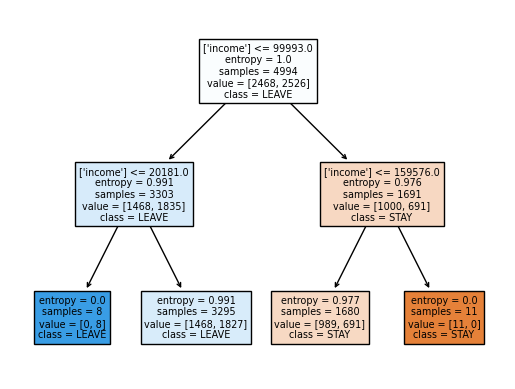

In [17]:
# Step 3: Visualize the money tree model
plot_tree(money_tree,
          feature_names=[['income']],
          class_names=['STAY', 'LEAVE'],
          filled=True)


Explanation of code:

- `plot_tree()`: Function from scikit-learn to visualize the decision tree
- `money_tree`: The fitted decision tree model to be visualized
- `feature_names=[['income']]`: Labels the feature as `income` in the tree diagram
- `class_names=['STAY', 'LEAVE']`: Specifies the names for the target classes in the visualization
- `filled=True`: Colorizes the nodes based on the majority class at each node


This plot is a bit confusing!  Here is an interpretive guide.

1. **Root Node (Top)**:
   - Split: income <= 99993.0
   - Samples: 4994
   - Initial prediction: LEAVE

2. **Second Level**:
   - Left Branch (income <= 20181.0):
     - Samples: 3303
     - Prediction: LEAVE
   - Right Branch (20181.0 < income <= 159576.0):
     - Samples: 1691
     - Prediction: STAY

3. **Third Level (Leaf Nodes)**:
   - Far Left (income <= 20181.0):
     - Samples: 8
     - Prediction: LEAVE (high certainty, entropy = 0.0)
   - Middle Left (20181.0 < income <= 99993.0):
     - Samples: 3295
     - Prediction: LEAVE (with uncertainty, entropy = 0.991)
   - Middle Right (99993.0 < income <= 159576.0):
     - Samples: 1680
     - Prediction: STAY (with uncertainty, entropy = 0.977)
   - Far Right (income > 159576.0):
     - Samples: 11
     - Prediction: STAY (high certainty, entropy = 0.0)



## Check Accuracy

What is the accuracy of the money_tree?


In [18]:
# 1. Generate predictions from the model for the training data
pred = money_tree.predict(X = mtc_clean[['income']])
print(pred)

['STAY' 'STAY' 'STAY' ... 'STAY' 'STAY' 'LEAVE']


Explanation of code:

- `money_tree.predict()`: Method to make predictions using the trained decision tree model
- `X = mtc_clean[['income']]`: Input data for prediction, using only the `income` column from the DataFrame
- Output: Returns an array of predicted class labels ('STAY' or 'LEAVE') for each row in the input data


In [19]:
# 2. Calculate accuracy as the proportion of correct predictions

# Your code goes here


sum(pred == mtc_clean['leave'])/len(pred)

0.5676812174609531

So, this is better than the accuracy of the majority class classifier, which was our benchmark.  Success!

Would a more complicated model have better performance measured in terms of accuracy?

## Overfitting

Refit the tree, only this time leave out the `max_depth` argument.  This will allow the tree to fit as complicated a model as possible.

In [22]:
# Your code goes here
money_tree = DecisionTreeClassifier(criterion = "entropy")
money_tree = money_tree.fit(X = mtc_clean[['income']],
                            y = mtc_clean['leave'])
plot_tree(money_tree,
          feature_names=[['income']],
          class_names=['STAY', 'LEAVE'],
          filled=True)

[Text(0.6702882659988018, 0.9961240310077519, "['income'] <= 99993.0\nentropy = 1.0\nsamples = 4994\nvalue = [2468, 2526]\nclass = LEAVE"),
 Text(0.558612117580282, 0.9883720930232558, "['income'] <= 20181.0\nentropy = 0.991\nsamples = 3303\nvalue = [1468, 1835]\nclass = LEAVE"),
 Text(0.5573289843292746, 0.9806201550387597, 'entropy = 0.0\nsamples = 8\nvalue = [0, 8]\nclass = LEAVE'),
 Text(0.5598952508312892, 0.9806201550387597, "['income'] <= 20351.0\nentropy = 0.991\nsamples = 3295\nvalue = [1468, 1827]\nclass = LEAVE"),
 Text(0.5245503394451976, 0.9728682170542635, "['income'] <= 20247.5\nentropy = 0.684\nsamples = 11\nvalue = [9, 2]\nclass = STAY"),
 Text(0.5232672061941903, 0.9651162790697675, 'entropy = 0.0\nsamples = 4\nvalue = [4, 0]\nclass = STAY'),
 Text(0.525833472696205, 0.9651162790697675, "['income'] <= 20312.0\nentropy = 0.863\nsamples = 7\nvalue = [5, 2]\nclass = STAY"),
 Text(0.5245503394451976, 0.9573643410852714, "['income'] <= 20284.0\nentropy = 0.918\nsamples = 3

Error in callback <function _draw_all_if_interactive at 0x7f5788093eb0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f5788093130> (for post_execute):


KeyboardInterrupt: 

Whoa!

What is the accuracy of this model?

In [23]:
# Your code goes here
pred = money_tree.predict(X = mtc_clean[['income']])
print(pred)

proportion = pd.Series(pred).value_counts(normalize=True)
print(proportion)


['LEAVE' 'LEAVE' 'STAY' ... 'STAY' 'STAY' 'LEAVE']
LEAVE    0.505607
STAY     0.494393
Name: proportion, dtype: float64


Killing it!

## Cross-validation

Or:  maybe not.  Will you get promoted or ... fired?

This model is excessively complicated.  It has figured out how to classify the target perfectly *in the training data*. It has essentially just memorize the training data.  However, when it encounters new data **it will suck**. That's because new data will have patterns that were not in the training data (this is the nature of sampling) and the overfit model will get badly confused.

To demonstrate this we will use cross-validation.

The simplest version of cross-validation uses a training set and a testing or validation set. (This is called the validation set method.) Simply, we divide the data that we have into two parts: 80% goes into the training set and 20% into the testing set. (80/20 is a common choice.) That division is done randomly using the `sample()` function.



In [24]:
# divide mtc_clean into train and test
train = mtc_clean.sample(frac=0.8, random_state=200) # 80% of data for training
test = mtc_clean.drop(train.index) # the remaining 20%


`random_state` is a seed that ensures the same split when set to 200 (an arbitrary choice). This will make our results comparable.

In [25]:
train.head()

,college,income,overage,leftover,house,handset_price,over_15mins_calls_per_month,average_call_duration,reported_satisfaction,reported_usage_level,considering_change_of_plan,leave,id
3773,yes,80751,0,54,298898,371,1.0,2,high,low,no,STAY,10317
2835,no,75827,0,58,169117,264,1.0,2,high,low,no,STAY,6724
432,no,114384,71,0,204766,814,5.0,14,low,low,yes,STAY,4530
3959,no,84795,0,14,914009,302,1.0,5,high,low,no,STAY,7738
409,no,85012,0,0,485532,380,0.0,9,high,low,no,LEAVE,7788


In [26]:
test.head()

,college,income,overage,leftover,house,handset_price,over_15mins_calls_per_month,average_call_duration,reported_satisfaction,reported_usage_level,considering_change_of_plan,leave,id
2,no,30883,60,0,647281,211,3.0,8,low,low,yes,STAY,7425
18,no,50117,216,0,156554,324,14.0,9,low,low,no,LEAVE,18537
19,no,64138,0,34,274984,268,0.0,1,low,low,no,LEAVE,3419
38,no,158711,192,57,271701,557,3.0,1,low,high,yes,LEAVE,8132
40,yes,67761,0,46,155536,316,0.0,1,high,high,yes,LEAVE,14134


The cross validation procedure is to create the model using the train data and then evaluate it--that is, get predictions--using the test data. Accuracy of the model is therefore calculated using the test data. This way, we get an accurate picture of how the model will perform in the wild, with new data.

Make sure to leave out the `max_depth` argument.

In [27]:
# Initialize the classifier.  Leave out max_depth
# Your code goes here
train_tree = DecisionTreeClassifier(criterion = "entropy")

In [28]:
# Fit the model using train
# Your code goes here
train_tree = train_tree.fit(X = train[['income']],
                            y = train['leave'])

plot_tree(train_tree,
          feature_names=[['income']],
          class_names=['STAY', 'LEAVE'],
          filled=True)

[Text(0.4803931832201834, 0.9954128440366973, "['income'] <= 99993.0\nentropy = 1.0\nsamples = 3995\nvalue = [1984, 2011]\nclass = LEAVE"),
 Text(0.0995652572536176, 0.9862385321100917, "['income'] <= 20137.5\nentropy = 0.991\nsamples = 2654\nvalue = [1180, 1474]\nclass = LEAVE"),
 Text(0.0980799206014852, 0.9770642201834863, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]\nclass = LEAVE'),
 Text(0.10105059390575002, 0.9770642201834863, "['income'] <= 20247.5\nentropy = 0.991\nsamples = 2651\nvalue = [1180, 1471]\nclass = LEAVE"),
 Text(0.0995652572536176, 0.9678899082568807, 'entropy = 0.0\nsamples = 4\nvalue = [4, 0]\nclass = STAY'),
 Text(0.10253593055788243, 0.9678899082568807, "['income'] <= 25346.0\nentropy = 0.991\nsamples = 2647\nvalue = [1176, 1471]\nclass = LEAVE"),
 Text(0.057139044336718854, 0.9587155963302753, "['income'] <= 23245.0\nentropy = 1.0\nsamples = 253\nvalue = [125, 128]\nclass = LEAVE"),
 Text(0.04985161138719419, 0.9495412844036697, "['income'] <= 23190.0\nentropy

Error in callback <function flush_figures at 0x7f5788093130> (for post_execute):


KeyboardInterrupt: 

In [29]:
# Predict using test
# Your code goes here
pred = train_tree.predict(X = test[['income']])
print(pred)

['LEAVE' 'LEAVE' 'STAY' 'LEAVE' 'STAY' 'STAY' 'STAY' 'STAY' 'STAY' 'STAY'
 'STAY' 'LEAVE' 'STAY' 'LEAVE' 'STAY' 'STAY' 'STAY' 'STAY' 'LEAVE' 'LEAVE'
 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE' 'STAY' 'STAY' 'LEAVE' 'LEAVE' 'STAY'
 'STAY' 'LEAVE' 'LEAVE' 'STAY' 'LEAVE' 'STAY' 'STAY' 'LEAVE' 'STAY' 'STAY'
 'STAY' 'LEAVE' 'LEAVE' 'STAY' 'LEAVE' 'LEAVE' 'LEAVE' 'STAY' 'LEAVE'
 'STAY' 'LEAVE' 'LEAVE' 'STAY' 'LEAVE' 'STAY' 'LEAVE' 'LEAVE' 'STAY'
 'LEAVE' 'STAY' 'STAY' 'STAY' 'STAY' 'LEAVE' 'LEAVE' 'STAY' 'LEAVE' 'STAY'
 'STAY' 'LEAVE' 'LEAVE' 'STAY' 'STAY' 'STAY' 'STAY' 'STAY' 'LEAVE' 'LEAVE'
 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE' 'STAY' 'STAY' 'STAY' 'LEAVE' 'LEAVE'
 'LEAVE' 'LEAVE' 'LEAVE' 'STAY' 'LEAVE' 'STAY' 'STAY' 'STAY' 'LEAVE'
 'LEAVE' 'STAY' 'LEAVE' 'LEAVE' 'LEAVE' 'STAY' 'STAY' 'STAY' 'STAY'
 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE' 'STAY' 'LEAVE' 'STAY' 'STAY' 'LEAVE'
 'LEAVE' 'LEAVE' 'LEAVE' 'STAY' 'LEAVE' 'STAY' 'LEAVE' 'LEAVE' 'STAY'
 'STAY' 'STAY' 'STAY' 'STAY' 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE' 'STAY' 'S

In [30]:
# Calculate model accuracy on the test set
# Your code goes here
sum(pred == test['leave'])/len(pred)

0.5125125125125125

Better or worse than the simpler model?  

Let's explore this further.  More complicated models are good--up to a point.  Choose a `max_depth` argument greater than 2 and see if you can improve on the simple model's accuracy without getting too complex and overfitting.

In [31]:
# Initialize the classifier--chose a max_depth > 2
# Your code goes here
train_tree = DecisionTreeClassifier(criterion = "entropy", max_depth = 4)

[Text(0.4642857142857143, 0.9, "['income'] <= 99993.0\nentropy = 1.0\nsamples = 3995\nvalue = [1984, 2011]\nclass = LEAVE"),
 Text(0.14285714285714285, 0.7, "['income'] <= 20137.5\nentropy = 0.991\nsamples = 2654\nvalue = [1180, 1474]\nclass = LEAVE"),
 Text(0.07142857142857142, 0.5, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]\nclass = LEAVE'),
 Text(0.21428571428571427, 0.5, "['income'] <= 20247.5\nentropy = 0.991\nsamples = 2651\nvalue = [1180, 1471]\nclass = LEAVE"),
 Text(0.14285714285714285, 0.3, 'entropy = 0.0\nsamples = 4\nvalue = [4, 0]\nclass = STAY'),
 Text(0.2857142857142857, 0.3, "['income'] <= 25346.0\nentropy = 0.991\nsamples = 2647\nvalue = [1176, 1471]\nclass = LEAVE"),
 Text(0.21428571428571427, 0.1, 'entropy = 1.0\nsamples = 253\nvalue = [125, 128]\nclass = LEAVE'),
 Text(0.35714285714285715, 0.1, 'entropy = 0.989\nsamples = 2394\nvalue = [1051, 1343]\nclass = LEAVE'),
 Text(0.7857142857142857, 0.7, "['income'] <= 159576.0\nentropy = 0.971\nsamples = 1341\nvalue = [80

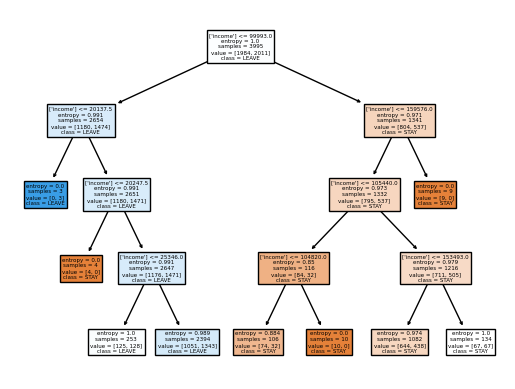

In [32]:
# Fit the model using train
# Your code goes here
train_tree = train_tree.fit(X = train[['income']],
                            y = train['leave'])

plot_tree(train_tree,
          feature_names=[['income']],
          class_names=['STAY', 'LEAVE'],
          filled=True)

In [33]:
# Predict using test
# Your code goes here
pred = train_tree.predict(X = test[['income']])
print(pred)

['STAY' 'STAY' 'STAY' 'LEAVE' 'STAY' 'STAY' 'STAY' 'STAY' 'STAY' 'LEAVE'
 'STAY' 'STAY' 'STAY' 'LEAVE' 'STAY' 'STAY' 'STAY' 'STAY' 'STAY' 'STAY'
 'LEAVE' 'LEAVE' 'STAY' 'STAY' 'STAY' 'STAY' 'LEAVE' 'STAY' 'LEAVE' 'STAY'
 'LEAVE' 'STAY' 'STAY' 'STAY' 'LEAVE' 'STAY' 'STAY' 'STAY' 'STAY' 'STAY'
 'LEAVE' 'STAY' 'STAY' 'LEAVE' 'LEAVE' 'STAY' 'STAY' 'STAY' 'LEAVE'
 'LEAVE' 'STAY' 'LEAVE' 'STAY' 'STAY' 'STAY' 'STAY' 'STAY' 'LEAVE' 'STAY'
 'STAY' 'STAY' 'STAY' 'LEAVE' 'STAY' 'LEAVE' 'STAY' 'LEAVE' 'STAY' 'STAY'
 'LEAVE' 'STAY' 'STAY' 'STAY' 'STAY' 'STAY' 'LEAVE' 'STAY' 'LEAVE' 'LEAVE'
 'LEAVE' 'STAY' 'LEAVE' 'LEAVE' 'STAY' 'STAY' 'STAY' 'STAY' 'STAY' 'STAY'
 'LEAVE' 'STAY' 'LEAVE' 'STAY' 'STAY' 'STAY' 'LEAVE' 'LEAVE' 'LEAVE'
 'LEAVE' 'STAY' 'STAY' 'LEAVE' 'STAY' 'STAY' 'LEAVE' 'STAY' 'LEAVE'
 'LEAVE' 'STAY' 'STAY' 'STAY' 'STAY' 'STAY' 'STAY' 'STAY' 'LEAVE' 'STAY'
 'LEAVE' 'STAY' 'STAY' 'LEAVE' 'STAY' 'STAY' 'LEAVE' 'STAY' 'STAY' 'LEAVE'
 'LEAVE' 'LEAVE' 'STAY' 'STAY' 'STAY' 'LEAVE' 'LEAVE' 'ST

In [34]:
# Calculate model accuracy on the test set
# Your code goes here
sum(pred == test['leave'])/len(pred)

0.5555555555555556

## Additional predictors

Pick one additional variable to use as a predictor--one that you think is a driver of churn at MegaTelCo, based on your EDA.

Refit the model using your best performing `max_depth` setting, with `income` and your chosen second predictor.

How does this model perform on the test set?

Adding a predictor makes for a more complicated model.  But complicated is good -- as long as it does not tip over into overfitting.

In [35]:
# Initialize the classifier--chose a max_depth > 2
# Your code goes here
another_tree = DecisionTreeClassifier(criterion = "entropy", max_depth = 6)

[Text(0.5151515151515151, 0.9285714285714286, 'house <= 600255.5\nentropy = 1.0\nsamples = 3995\nvalue = [1984, 2011]\nclass = LEAVE'),
 Text(0.22537878787878787, 0.7857142857142857, 'house <= 247259.0\nentropy = 0.976\nsamples = 2618\nvalue = [1546, 1072]\nclass = STAY'),
 Text(0.10606060606060606, 0.6428571428571429, 'house <= 243167.0\nentropy = 0.995\nsamples = 854\nvalue = [463, 391]\nclass = STAY'),
 Text(0.07575757575757576, 0.5, 'house <= 242218.0\nentropy = 0.993\nsamples = 825\nvalue = [454, 371]\nclass = STAY'),
 Text(0.06060606060606061, 0.35714285714285715, 'income <= 79013.5\nentropy = 0.993\nsamples = 820\nvalue = [449, 371]\nclass = STAY'),
 Text(0.030303030303030304, 0.21428571428571427, 'income <= 74184.5\nentropy = 1.0\nsamples = 443\nvalue = [225, 218]\nclass = STAY'),
 Text(0.015151515151515152, 0.07142857142857142, 'entropy = 0.998\nsamples = 419\nvalue = [220, 199]\nclass = STAY'),
 Text(0.045454545454545456, 0.07142857142857142, 'entropy = 0.738\nsamples = 24\nv

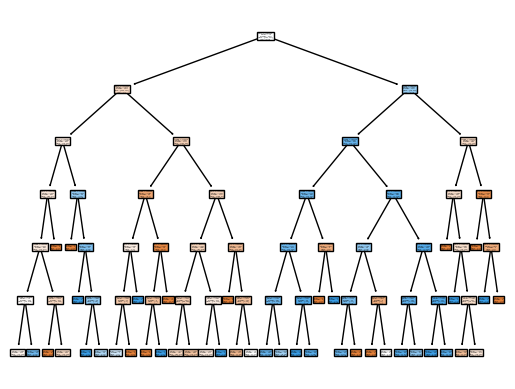

In [36]:
# Fit the model using train
# Your code goes here
another_tree = another_tree.fit(X = train[['income','house']],
                                y = train['leave'])

plot_tree(another_tree,
          feature_names=['income', 'house'], # Updated feature names to match training data
          class_names=['STAY', 'LEAVE'],
          filled=True)

In [37]:
# Predict using test
# Your code goes here
pred = another_tree.predict(X = test[['income','house']])
print(pred)

['STAY' 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE' 'STAY' 'STAY' 'LEAVE' 'LEAVE'
 'STAY' 'LEAVE' 'LEAVE' 'STAY' 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE'
 'LEAVE' 'LEAVE' 'LEAVE' 'STAY' 'LEAVE' 'STAY' 'LEAVE' 'LEAVE' 'LEAVE'
 'LEAVE' 'STAY' 'STAY' 'LEAVE' 'STAY' 'STAY' 'LEAVE' 'LEAVE' 'LEAVE'
 'LEAVE' 'STAY' 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE' 'STAY' 'LEAVE' 'LEAVE'
 'LEAVE' 'STAY' 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE' 'STAY' 'STAY'
 'LEAVE' 'LEAVE' 'STAY' 'STAY' 'STAY' 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE'
 'STAY' 'LEAVE' 'STAY' 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE'
 'LEAVE' 'LEAVE' 'STAY' 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE' 'STAY'
 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE' 'STAY' 'LEAVE' 'STAY' 'LEAVE' 'LEAVE'
 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE'
 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE' 'LEAVE'
 'STAY' 'STAY' 'LEAVE' 'LEAVE' 'LEAVE' 'STAY' 'LEAVE' 'LEAVE' 'LEAVE'
 'LEAVE' 'STAY' 'LEAVE' 'LEAVE' 'STAY' 'LEAVE' 'LEAVE' 'STAY' 'LEAVE'
 'LEAVE' 

In [38]:
# Calculate model accuracy on the test set
# Your code goes here
sum(pred == test['leave'])/len(pred)

0.6186186186186187